# Neutrino oscillations - part 2 (10 Points)

1. Assuming you have fitted the data using the  $\chi^2$  method (explain why it’s fine), create a normalized histogram of $\chi^2$ -values. Overlay it with a  $\chi^2$  -distribution for the appropriate degrees of freedom and compare mean and variances of the two distributions.

* we precily know the x values (cosdec =  np.linspace(0, 1, N) and log10_energy = np.linspace(1, 2, N))
* we can generate y values with a accuracy $\sigma$
* and we have a given function $P = 1 -\sin^2(2\theta)\sin^2(1.27\frac{\Delta m^2 L}{E})$
    with the two mixig parameters $\sin^2(2\theta)$ (sin2theta) and $\Delta m^2$ (dm2)
    
    $$\chi^2 = \sum_i\frac{(y_i - f(x_i))^2}{\sigma_i^2}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
import scipy.optimize as so
from scipy.stats import poisson
from scipy.stats import chi2

In [2]:
#using the functions provided in the example notebook in the Github repository, which already includes reasonable default parameters
#I just added a **2 to the sin(), like in the formula above
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 #shouldn't it be sin2theta and np.sin()**2 ?

    return flux*osc_prop

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)

    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            
            i=i+1
                   
    return events

# funktion to generate data of one experiment, with N energy bins and N cos(declination) bins
def generate_data(N, sin2theta=0.9, dm2=2.4e-3):
    cosdec =  np.linspace(0, 1, N) # N steps in cos(declination) from 0 to 1 
    log10_energy = np.linspace(1, 2, N) # N steps in log10(energy) from 10 to 100 GeV
    energy=10**log10_energy
# run the experiment 
    events=run_experiment(energy,cosdec, sin2theta, dm2)

# lets create a data set with the events per bin
# energy, cosdec, events
    data = [[], [], []]
    i = 0
    for e in energy:
        for c in cosdec:
            data[0].append(e)
            data[1].append(c)
            data[2].append(events[i])#"energy, cosdec, events:",e,c, events[i])
            i=i+1
    return data

def chi_squared(param):
    sin2theta, dm2 = param 
    df = generate_data(10)
    energy, cosdec, events = df[0], df[1], df[2]
    chi2 = []
    i = 0
    for i in range(len(energy)):
        mu = atmo_event_rate(energy[i], cosdec[i],sin2theta,dm2) # also f(x) = atmo_event_rate(energy, cosdec,sin2theta,dm2)
        chi2.append((events[i] - mu)**2/mu) #sigma = sqrt(mu)
    return np.sum(chi2)

In [3]:
#fitting data with chi2
sin2theta, dm2 = [0.9, 2.4e-3]
model = so.minimize(chi_squared, x0 = [sin2theta, dm2],  bounds=[(0,10), (-10,10)])
print(model)

      fun: 128.9925525830908
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.54175451e+09,  4.56396373e+07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 2
     njev: 15
   status: 0
  success: True
        x: array([0.89999764, 0.00240661])


In [4]:
# creating a normalized histogram of chi2
N = 1000
chi2array = []
for i in range(N):
    sin2theta, dm2 = [0.9, 2.4e-3]
    model = so.minimize(chi_squared, x0 = [sin2theta, dm2],  bounds=[(0,10), (-10,10)])
    if model["success"] == True and model["fun"] >= 0:
        chi2array.append(model["fun"])

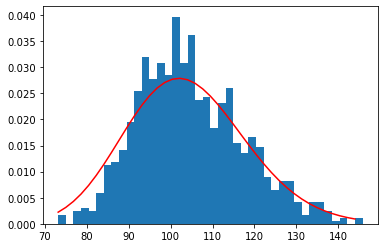

In [5]:
df = 104 
bins = 40
h, w = np.histogram(chi2array, bins)
#h = h/sum(h)
pdf = chi2.pdf(w[:-1], df=df)
plt.hist(chi2array, bins = bins, density = True)
#plt.bar(w[:-1], h , width = w[1]-w[0]) 
plt.plot(w[:-1], pdf, "r")

In [14]:
pdf

array([0.00222817, 0.00313733, 0.00428737, 0.00569435, 0.00736013,
       0.00926922, 0.01138699, 0.01365981, 0.01601703, 0.01837498,
       0.0206424 , 0.02272694, 0.02454183, 0.02601218, 0.02708018,
       0.02770867, 0.02788292, 0.0276105 , 0.02691942, 0.02585482,
       0.02447484, 0.02284588, 0.02103791, 0.01912017, 0.0171575 ,
       0.01520758, 0.01331904, 0.01153049, 0.00987036, 0.0083574 ,
       0.00700161, 0.00580556, 0.00476578, 0.00387425, 0.00311974,
       0.00248908, 0.00196813, 0.00154264, 0.00119886, 0.00092398])

2. What is the χ2-value that corresponds to the cumulative 67% percent of the distribution?: 1 sigma


In [15]:
#pdf_mean, pdf_var =np.mean(pdf), np.var(pdf)
chi_mean, chi_var =np.mean(chi2array), np.var(chi2array)
#print("pdf_mean, pdf_var:" + str(pdf_mean) + "," + str(pdf_var))
print("chi_mean, chi_var:" + str(chi_mean) + "," + str(chi_var))

chi_mean, chi_var:104.7075939320496,157.7225254225225


# COVID-19 self-testing and Bayesian theorem (5 Points)

#### Imaginary Test
* Given a COVID-19 infection, these tests only indicate a positive test result 60% of the time 
* a 1% chance that the test shows a positive result, despite no infection.
#### 1. Cast these numbers as Type I and Type II errors.
##### Type I error 
is the mistaken rejection of an actually true null hypothesis (also known as a "false positive")- The Probability to be tested positive although not having covid-19 - here $P(E+|-H) = 0.01$ is the probability of being falsly identified
##### Type II error 
is the failure to reject a null hypothesis that is actually false (also known as a "false negative") $P(E-|H) = 0.4$  The Probability to be tested negative although having covid-19 

#### 2. 2. Use Bayes’ theorem to compute the probability to be healthy, as a function of COVID- 19 prevalence in the general population, and display it in a graph ranging from 10−6 to 1). - I am guessing after a positive or a negative test

Lets start with the probabiliy of being healthy after a positive test result $P(-H|E+)$.

$-H$: Not Having Covid - Healthy

$H$:  Having Covid

$E-$: Negative Test Event

$E+$: Positive Test Event
#### Bayes’ theorem:

$$P(-H|E+) = \frac{P(E+|-H)P(-H)}{P(E+)} = \frac{P(E+|-H)P(-H)}{P(E+|H)P(H) + P(E+|-H)P(-H)} $$
with $P(H) = 1 -P(-H)$
$$= \frac{0.01 P(-H)}{0.6(1 - P(-H)) + 0.01 P(-H)}$$



In [7]:
def BayesHealthyPositiveTest(p):
    return 0.01*(1-p)/(0.6*(p)+0.01*(1-p))

In [8]:
propHealthy = []
log10_prevalence = np.linspace(-6, 0, 100)
prevalence = 10**log10_prevalence #np.linspace(0, 1, 100)#
for p in prevalence:
    propHealthy.append(BayesHealthyPositiveTest(p))
    

Text(0, 0.5, 'probability to be healthy after positve test')

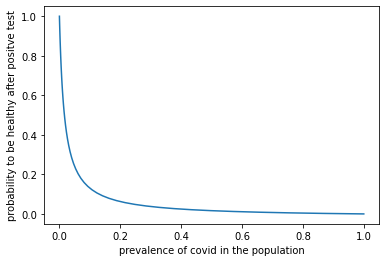

In [9]:
plt.plot(prevalence, propHealthy)
plt.xlabel("prevalence of covid in the population")
plt.ylabel("probability to be healthy after positve test")
#plt.yscale("log")

Next the probabiliy of being healthy after a negative test result $P(-H|E-)$.

$-H$: Not Having Covid - Healthy

$H$:  Having Covid

$E-$: Negative Test Event

$E+$: Positive Test Event
#### Bayes’ theorem:

$$P(-H|E-) = \frac{P(E-|-H)P(-H)}{P(E-)} =     \frac{P(E-|-H)P(-H)}{P(E-|H)P(H) + P(E-|-H)P(-H)} $$
with $P(H) = 1 -P(-H)$
$$= \frac{0.99 P(-H)}{0.4(1 - P(-H)) + 0.99 P(-H)}$$



In [10]:
def BayesHealthyNegativeTest(p):
    return 0.99*(1-p)/(0.4*(p)+0.99*(1-p))

Text(0, 0.5, 'probability to be healthy after negative test')

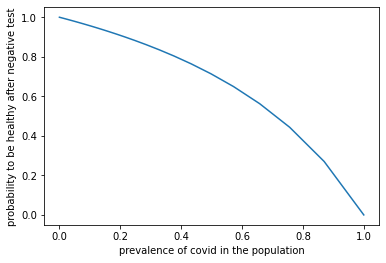

In [11]:
propHealthy = []
log10_prevalence = np.linspace(-6, 0, 100)
prevalence = 10**log10_prevalence
for p in prevalence:
    propHealthy.append(BayesHealthyNegativeTest(p))
    
plt.plot(prevalence, propHealthy)
plt.xlabel("prevalence of covid in the population")
plt.ylabel("probability to be healthy after negative test")
#plt.yscale("log")